In [153]:
import seaborn as sns
import ssl
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
from itertools import combinations
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tabulate import tabulate

ssl._create_default_https_context = ssl._create_stdlib_context

# Apply the default theme
sns.set_theme()


In [22]:
data_folder = "../data"

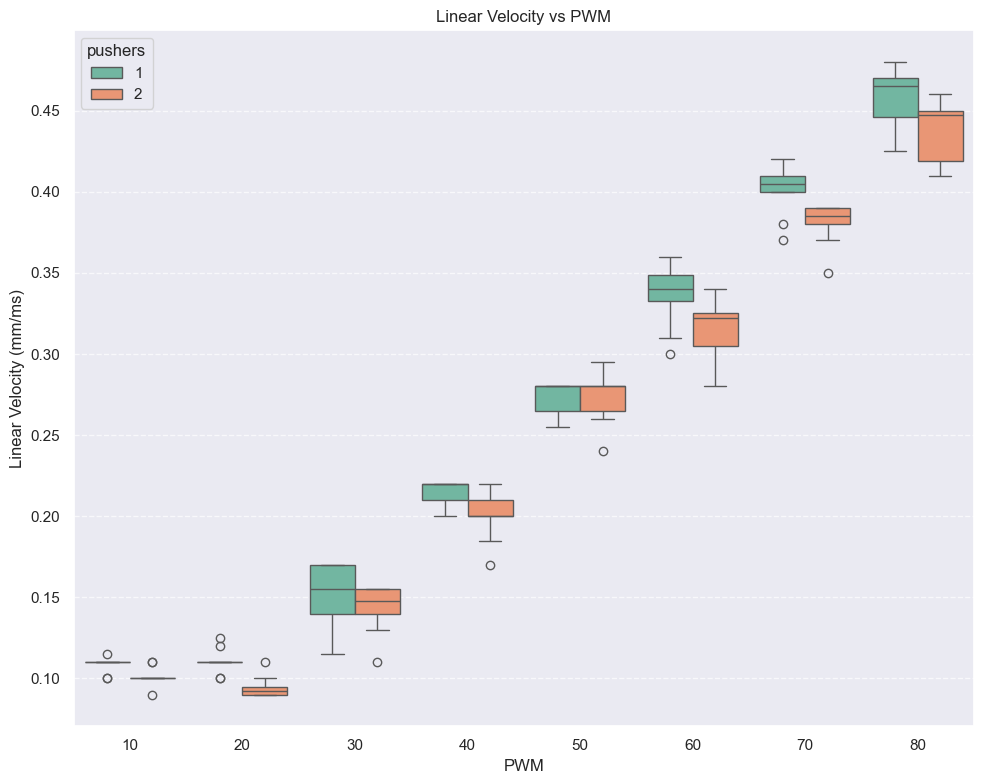

In [217]:
# Plot robot pwm / speed relationship
robot_names = ["ken", "monish"]

def compute_similarity(data_a, data_b):
    
    similarities = {}
    for column in data_a.columns:
        # Calculate Pearson correlation for the column
        corr, _ = pearsonr(data_a[column], data_b[column])
        similarities[column] = corr  # Save correlation coefficient
    
    # Aggregate the similarities (mean of all columns)
    return np.mean(list(similarities.values()))

raw_data = []
for robot_name in robot_names:
    file_path = os.path.join(data_folder, f"bot_{robot_name}.csv")
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()  # Remove extra spaces in column names
    df["pushers"] = robot_names.index(robot_name) + 1
    df["average_speed"] =  (df['left_speed'] + df['right_speed']) / 2
    # Filter PWM values between 0 and 80
    df = df[df["pwm"].between(0, 80)]
    raw_data.append(df)

n_datasets = len(raw_data)
combined_data = pd.concat(raw_data, ignore_index=True)

# Create a melted DataFrame for easier plotting
melted_data = combined_data.melt(id_vars=["pushers"], var_name="Characteristic", value_name="Value")

# Set up the plotting area
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8), sharey=True)
# Plot speed vs PWM
sns.boxplot(data=combined_data, x="pwm", y="average_speed", hue="pushers", ax=ax1, palette='Set2')
ax1.set_title("Linear Velocity vs PWM")
ax1.set_xlabel("PWM")
ax1.set_ylabel("Linear Velocity (mm/ms)")
ax1.grid(axis="y", linestyle="--", alpha=0.7)


# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [207]:
def load_trajectory_data(folder_path, method, prefix, robot):
    raw_data = []
    for i in range(1, 11):
        file_path = os.path.join(folder_path, f"{prefix}_{robot}_{i}.csv")
        df = pd.read_csv(file_path)
        df.columns = df.columns.str.strip()
        df["average_speed"] = (df['left_speed'] + df['right_speed']) / 2
        df["trajectory_id"] = i
        df["method"] = method
        df["y_error"] = df["y"]
        df["bump_balance"] = df["left_bump"] - df["right_bump"]
        raw_data.append(df)
    return pd.concat(raw_data, ignore_index=True)

In [204]:
from scipy import interpolate

def interpolate_trajectories(trajectory_data, new_x):
    interpolated_data = []
    
    # Interpolate each trajectory separately
    for traj_id in trajectory_data['trajectory_id'].unique():
        traj = trajectory_data[trajectory_data['trajectory_id'] == traj_id]
        
        # Create interpolation function for this trajectory
        interp_func = interpolate.interp1d(
            traj['x'], 
            traj['y_error'],
            kind='linear',
            fill_value='extrapolate'
        )
        
        # Interpolate y_error for new x values
        new_y_error = interp_func(new_x)
        
        # Create DataFrame for this interpolated trajectory
        interpolated_df = pd.DataFrame({
            'x': new_x,
            'y_error': new_y_error,
            'method': traj['method'].iloc[0],
            'trajectory_id': traj_id
        })
        
        interpolated_data.append(interpolated_df)
    
    return pd.concat(interpolated_data, ignore_index=True)

def plot_interpolated_trajectories(interpolated_data_dict, ax):
    # Combine all data with method labels
    combined_data = pd.concat([
        df.assign(method=method) 
        for method, df in interpolated_data_dict.items()
    ], ignore_index=True)
    
    # Create boxplot
    sns.boxplot(
        x='x', 
        y='y_error', 
        hue='method', 
        data=combined_data, 
        palette="Set2",
        ax=ax,
    )
    
    ax.set_xlabel("Distance [mm]")
    ax.set_ylabel("Translation error [mm]")
    return ax

In [210]:
def plot_bumper(data_dict, ax):
    # Combine all data with method labels
    combined_data = pd.concat([
        df.assign(method=method) 
        for method, df in data_dict.items()
    ], ignore_index=True)
    
    # Create boxplot
    sns.lineplot(
        x='x', 
        y='bump_balance', 
        hue='method', 
        data=combined_data, 
        palette="Set2",
        ax=ax,
    )
    
    ax.set_xlabel("Distance [mm]")
    ax.set_ylabel("Bumper Value [μs]")
    return ax

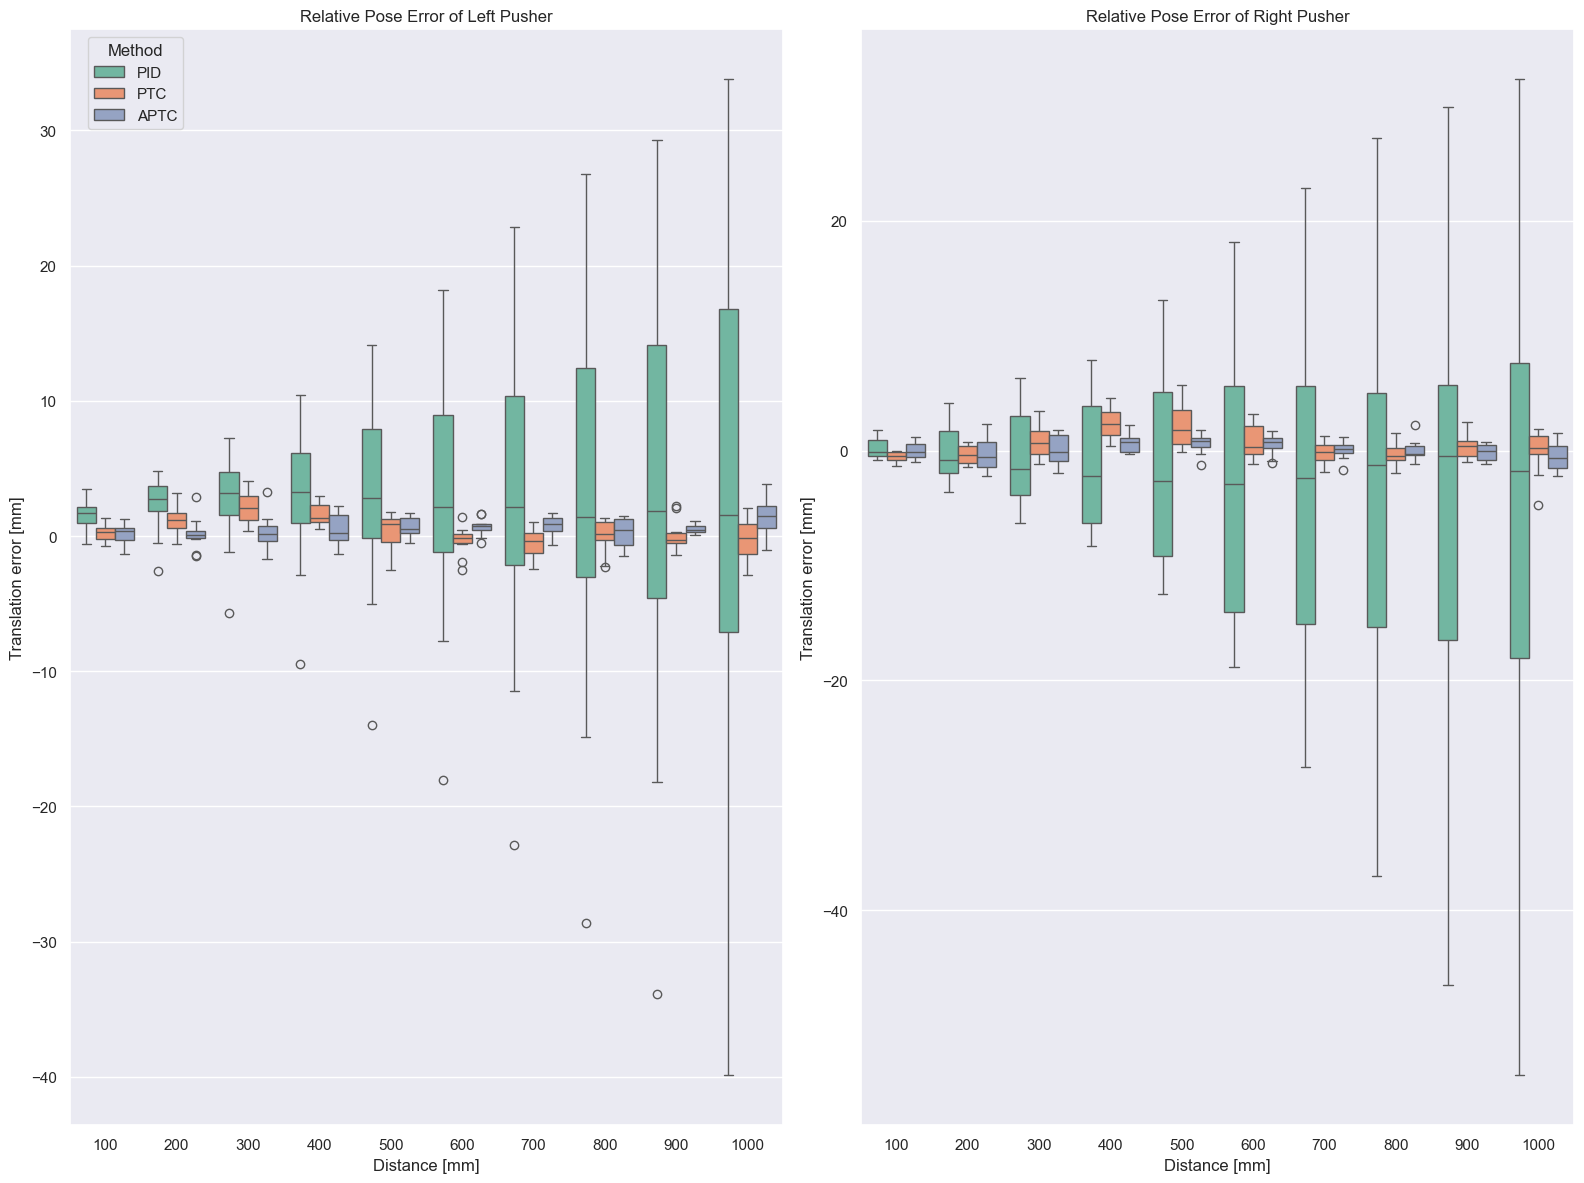

In [225]:
folder_name = {
    "PID": ["PID", "pid_baseline"] , 
    "PTC2":["PTC", "ptc2_baseline"],
    "LF" : ["APTC", "improvement"]
}
methods_data_left, methods_data_right = {}, {}
raw_data_left, raw_data_right = {}, {}

for k, v in folder_name.items():
    method, prefix = folder_name[k]
    trajectory_data_left = load_trajectory_data(os.path.join(data_folder, k), method, prefix, "left")
    trajectory_data_right = load_trajectory_data(os.path.join(data_folder, k), method, prefix, "right")
    new_x = np.linspace(100, 1000, num=10, dtype=int)
    interpolated_data_left = interpolate_trajectories(trajectory_data_left, new_x)
    interpolated_data_right = interpolate_trajectories(trajectory_data_right, new_x)
    methods_data_left[method] = interpolated_data_left
    methods_data_right[method] = interpolated_data_right
    raw_data_left[method] = trajectory_data_left
    raw_data_right[method] = trajectory_data_right
    

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
ax1 = plot_interpolated_trajectories(methods_data_left, ax1)
ax1.set_title("Relative Pose Error of Left Pusher")
# ax1.set_ylim([-5, 5])
ax1.legend(title='Method', bbox_to_anchor=(0.17, 1), loc='upper right')
ax2 = plot_interpolated_trajectories(methods_data_right, ax2)
ax2.set_title("Relative Pose Error of Right Pusher")
# ax2.set_ylim([-5, 5])
ax2.legend().remove()
# ax3 = plot_bumper(raw_data_left, ax3)
# ax3.legend().remove()
# ax4 = plot_bumper(raw_data_right, ax4)
# ax4.legend().remove()
plt.tight_layout()
plt.show()

